### Here is the title and the plan

1. Import needed libraries and classes.
2. Load the dataset and visualize the count distribution per label.
3. Use Autotune for better performance (optimizes the hardware usage). Also cache and prefetch data.
4. Augment the data by modifying the training images slightly each time with a random action.
5. Create the Convolutional Neural Network (CNN), compile it and then train it (target 90% valuation accuracy).
6. Evaluate the model performance until satisfactory.
7. Error evaluation.


In [1]:
# import libraries and modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from translate import translate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

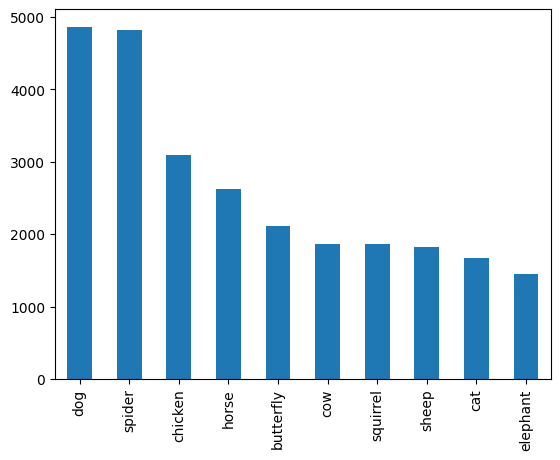

In [2]:
# load the dataset and create a dataframe with the image paths and labels

dataset_path = r"C:\Users\Danail Arabadzhiev\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2\raw-img"
data = []
name_num_dict = {"cane": 0, "cavallo": 1, "elefante": 2, "farfalla": 3, "gallina": 4, "gatto": 5, "mucca": 6, "pecora": 7,
                  "scoiattolo": 8, "dog": 0, "horse": 1, "elephant": 2, "butterfly": 3, "chicken": 4, "cat": 5, "cow": 6, "spider": 9, "squirrel": 8}


for label in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, label)

    if os.path.isdir(folder_path):
        for image in os.listdir(folder_path):
            data.append((os.path.join(folder_path, image), label))

df = pd.DataFrame(data, columns=["image_path", "label"])
df = df.sample(frac=1).reset_index(drop=True)
df['label'] = df['label'].replace(translate)
df['label'] = df['label'].replace('ragno', 'spider')
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')
df.to_csv("image_data.csv", index=False)

In [3]:
# load the dataset and create a dataframe with the image paths and labels

IMG_SIZE = 224 # set the image size
BATCH_SIZE = 32 # set the batch size
SEED_VALUE = 123 # set the seed value

train_ds = tf.keras.preprocessing.image_dataset_from_directory( # create a dataset from a directory
    dataset_path, # path to the directory
    validation_split=0.2, # 20% of the data will be used for validation
    subset="training", # specify that this is the training data
    seed=SEED_VALUE, # set seed for reproducibility
    image_size=(IMG_SIZE, IMG_SIZE), # resize the images to IMG_SIZE x IMG_SIZE
    batch_size=BATCH_SIZE # set the batch size
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory( # create a dataset from a directory
    dataset_path, # path to the directory
    validation_split=0.2, # 20% of the data will be used for validation
    subset="validation", # specify that this is the validation data
    seed=SEED_VALUE, # set seed for reproducibility
    image_size=(IMG_SIZE, IMG_SIZE), # resize the images to IMG_SIZE x IMG_SIZE
    batch_size=BATCH_SIZE # set the batch size
)

class_names = train_ds.class_names # get the class names
class_names
# for images, labels in train_ds.take(1):
#     for i in range(32):
#         ax = plt.subplot(6, 6, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [4]:
# Optimize the dataset performance

AUTOTUNE = tf.data.AUTOTUNE # set the AUTOTUNE parameter (automatically tune the data pipeline based on the available hardware)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # cache, shuffle, and prefetch the training dataset (this speeds up the training process as the data does not need to be loaded every time)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # cache and prefetch the validation dataset (prefetch means that the GPU can train on one batch while the CPU is preparing the next batch)


In [5]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([ # create a data augmentation layer
    tf.keras.layers.RandomFlip("horizontal"), # randomly flip the image horizontally
    tf.keras.layers.RandomRotation(0.1), # randomly rotate the image
    tf.keras.layers.RandomZoom(0.1), # randomly zoom into the image
    tf.keras.layers.RandomContrast(0.1), # randomly adjust the contrast of the image - added later on after 40 epochs
    tf.keras.layers.RandomBrightness(0.1), # randomly adjust the brightness of the image - added later on after 40 epochs
    tf.keras.layers.GaussianNoise(0.05) # add random noise to the image - added later on after 40 epochs
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)) # apply the data augmentation to the training dataset

In [6]:
# # Create the model - DCNN


# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # preprocess the input

old_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)), # extracts 32 feature maps using a 3x3 filter. Takes as an input an image of size 224x224 with 3 colors (RGB)
    tf.keras.layers.MaxPooling2D(2, 2), # reduces the size of the image by taking the maximum value in a 2x2 square
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu'), # added an additional convolutional layer after 40 epochs
    # tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(), # flattens the input. Converts the 3d feature maps to a 1D array
    tf.keras.layers.Dense(512, activation='relu'), # fully connected layer with 512 neurons
    tf.keras.layers.Dropout(0.5), # randomly sets 50% of the input units to 0 at each update during training to prevent overfitting
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Output layer with classes
])

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

old_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # compile the model

old_model.summary() # display the model summary


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)     

In [7]:
# Load the model weights (after training for 40 epochs) (this is optional and should be used after tuning the model structure and hyperparameters)

old_model.load_weights("image_classification_DCNN_weights.h5")

In [8]:
# Additional: Adding a new layer to the CNN changes the structure and old weights will not fit. We need to freeze the old layers, add new layers, train them and then finetune everything.

num_classes = old_model.layers[-1].output_shape[-1]  # Get class names (needed for the final layer)

# Define a new model with the additional Conv2D(256) layer
new_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), name="conv2d"),
    tf.keras.layers.MaxPooling2D(2, 2, name="max_pooling2d"),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name="conv2d_1"),
    tf.keras.layers.MaxPooling2D(2, 2, name="max_pooling2d_1"),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name="conv2d_2"),
    tf.keras.layers.MaxPooling2D(2, 2, name="max_pooling2d_2"),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', name="conv2d_3"),  # New layer v.2
    tf.keras.layers.MaxPooling2D(2, 2, name="max_pooling2d_3"),  # New pooling layer v.2

    tf.keras.layers.Flatten(name="flatten"),  # flatten the input
    tf.keras.layers.Dense(512, activation='relu', name="dense"),
    tf.keras.layers.Dropout(0.5, name="dropout"),
    tf.keras.layers.Dense(num_classes, activation='softmax', name="dense_1")
])


In [9]:
# new model load weights

new_model.load_weights(f"IC_DCNN-256_weights_seed-{SEED_VALUE}-3.h5", by_name=True)

In [ ]:
# # Check the name of the layers in the old and new model

# for layer in old_model.layers:
#     print(f"Layers in old model: {layer.name}")

# for layer in new_model.layers:
#     print(layer.name)

In [ ]:
# Transfer weights from the old model for the matching layers

# for layer in new_model.layers:
#     try:
#         new_layer = new_model_1.get_layer(layer.name)  # Get layer by name
#         if new_layer.get_weights():  # Check if the layer has weights
#             new_layer.set_weights(layer.get_weights())  # Transfer weights
#             print(f"✅ Transferred weights for layer: {layer.name}")
#     except ValueError as e:
#         print(f"❌ Skipping layer {layer.name} due to shape mismatch: {e}")

In [ ]:
# # Test if the weights have been updated successfully

# old_weights = new_model.get_layer("conv2d").get_weights()

# new_weights = new_model_1.get_layer("conv2d").get_weights()

# for ow, nw in zip(old_weights, new_weights):
#     print(np.allclose(ow, nw))

In [ ]:
# Freeze the old layers

# for layer in new_model.layers[:-3]:
#     layer.trainable = False

In [ ]:
# # Unfreeze the new layers

# for layer in new_model.layers:
#     layer.trainable = True

#### We can use ModelCheckpoint to automatically save weights

In [10]:
# Define the callbacks

early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True) # stop training if the validation loss does not improve after 3 epochs// changed to 7 after 40 epochs

checkpoint_new_model = ModelCheckpoint(f"IC_DCNN-256_weights_seed-{SEED_VALUE}-3.h5", monitor='val_accuracy' ,save_best_only=True, save_weights_only=True) # save the best model

lr_learner = ReduceLROnPlateau(monitor='val_accuracy',  # Monitor validation loss
                                           factor=0.5, # Reduce learning rate by half
                                           patience=5, # Wait for 3 epochs before reducing
                                           min_lr=1e-7, # Set a minimum learning rate
                                           verbose=1 # Print when reducing LR
                                           )

# checkpoint_new_model_v2 = ModelCheckpoint(f"IC_DCNN-256_weights_seed-{SEED_VALUE}-v2.h5", monitor='val_accuracy' ,save_best_only=True, save_weights_only=True) # save the best model



In [11]:
# Compile with a slightly higher learning rate to train the new layers
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:

# Train only the new layers
new_model.fit(train_ds,
              validation_data=val_ds,
              epochs=30,
              verbose=1,
              callbacks=[lr_learner, checkpoint_new_model, early_stopping])
                      

In [ ]:
# save the model weights

new_model.save(f"IC_DCNN-256_weights_seed-{SEED_VALUE}-model.h5")

In [19]:
# Evaluate the model

test_loss, test_accuracy = old_model.evaluate(val_ds) # evaluate the model on the validation dataset
print(f"Test accuracy old model: {test_accuracy: .3%}") # print the test accuracy
test_loss, test_accuracy = new_model.evaluate(val_ds) # evaluate the model on the validation dataset
print(f"Test accuracy new model: {test_accuracy: .3%}") # print the test accuracy


164/164 [==============================] - 18s 102ms/step - loss: 0.9964 - accuracy: 0.6787
Test accuracy old model:  67.870%
164/164 [==============================] - 19s 112ms/step - loss: 0.4857 - accuracy: 0.8665
Test accuracy new model:  86.648%


1/1 [==============================] - 0s 195ms/step


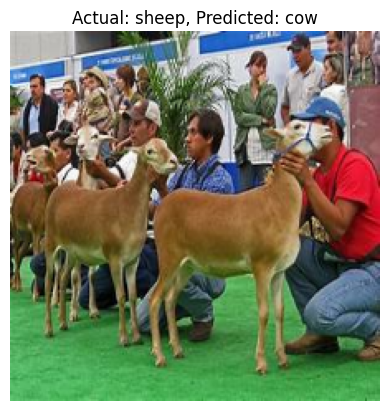

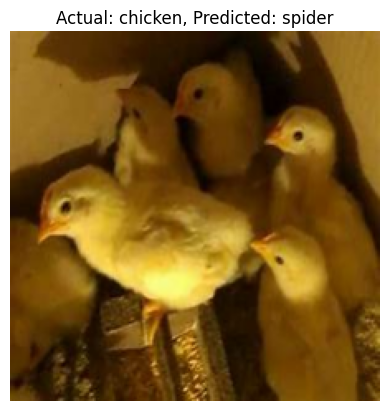

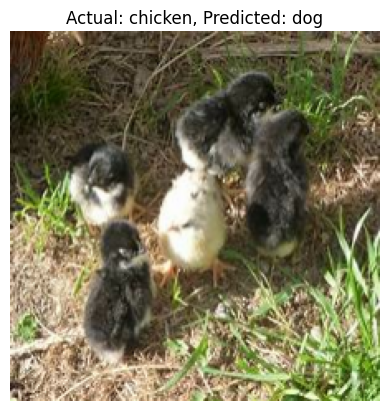

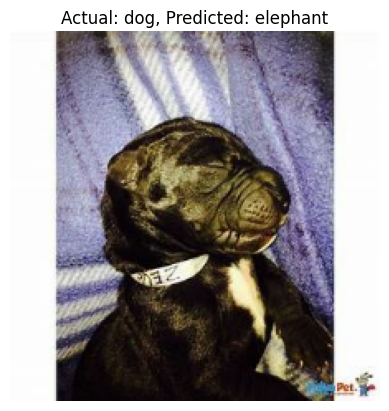

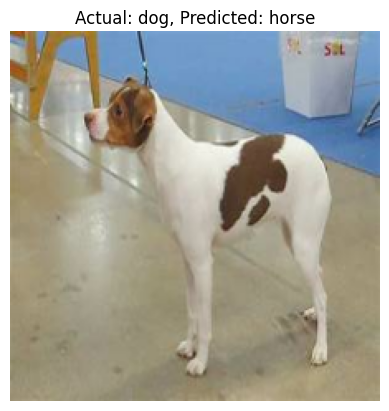

In [ ]:
# Predictions and visualizations of the wrong predictions

for images, labels in val_ds.take(1):
    predictions = new_model.predict(images)
    predictions = np.argmax(predictions, axis=1)
    dict_predictions = {0 : "dog", 1 : "horse", 2 : "elephant", 3 : "butterfly", 4 : "chicken", 
                        5 : "cat", 6 : "cow", 7 : "sheep", 8 : "squirrel", 9 : "spider"}
    for i in range(32):
        if labels[i].numpy() != predictions[i]:
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Actual: {dict_predictions[int(labels[i].numpy())]}, Predicted: {dict_predictions[int(predictions[i])]}")
            plt.axis("off")
            plt.show()